<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Text_classification/news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification

In [ ]:
%%capture
!pip install datasets

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data preparation

In [ ]:
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
words = Counter()
for example in tqdm(dataset['train']['text']):
  processed_text = example.lower().translate(str.maketrans('', '', string.punctuation))
  for word in word_tokenize(processed_text):
    words[word] += 1

  0%|          | 0/120000 [00:00<?, ?it/s]

In [ ]:
tags = ['<unk>', '<bos>',' <eos>', '<pad>']
vocab = set(tags)
counter_threshold = 25

In [ ]:
for char, count in words.items():
  if count > counter_threshold:
    vocab.add(char)

In [ ]:
word2idx = {char:i for i, char in enumerate(vocab)}
idx2word = {i:char for char, i in word2idx.items()}

### WordDataset class

In [ ]:
class WordDataset:
  def __init__(self, sent):
    self.data = sent
    self.unk_id, self.bos_id, self.eos_id, self.pad_id  = [word2idx[tag] for tag in tags]




  def ___getitem__(self, idx: int) -> list:
    processed_txt = self.data[idx]['text'].lower().translate(str.maketrans('', '', string.punctuation))
    tok_sent = [self.bos_id]
    tok_sent += [word2idx.get(word, self.unk_id) for word in word_tokenize(processed_txt)]
    tok_sent += [self.eos_id]

    train_sample = {
        'text': tok_sent,
        'label': self.data[idx]['label']
    }
    return train_sample
  def __getitem__(self, idx: int) -> dict:
    processed_txt = self.data[idx]['text'].lower().translate(str.maketrans('', '', string.punctuation))
    tok_sent = [self.bos_id]
    tok_sent += [word2idx.get(word, self.unk_id) for word in word_tokenize(processed_txt)]
    tok_sent += [self.eos_id]

    train_sample = {
        'text': tok_sent,
        'label': self.data[idx]['label']
    }
    return train_sample


  def __len__(self) -> int:
    return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2idx["<pad>"], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for seq in input_batch:
        seq['text'] = seq['text'][:max_seq_len]
        for _ in range(max_seq_len - len(seq['text'])):
            seq['text'].append(pad_id)

        new_batch.append(seq['text'])

    seqs = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)
    return {'input_idx': seqs, 'label': labels}



def collate_fn_with_padding_2(input_batch, pad_id, max_len):
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)
    new_batch = []
    labels = []
    for item in input_batch:
        p_seq = item['text'][:max_seq_len] + [pad_id] * (max_seq_len - len(item['text']))
        new_batch.append(p_seq)
        labels.append(item['label'])
    seqs = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor(labels).to(device)
    return {'input_idx': seqs, 'label': labels}


### Split and load data

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Task

Get highest score with evaluate func

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_idx'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Experiment

### Baseline

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, vocab_size: int, hidden_dim: int = 512, num_classes: int = 4, bi = False, rnn_layers = 2):
    super(RNNModel, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
    self.drop = nn.Dropout(0.2)
    self.rnn = nn.RNN(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=rnn_layers, batch_first=True, bidirectional=bi)
    self.fc_1 = nn.Linear(in_features=hidden_dim*(bi+1), out_features=hidden_dim//2)
    self.fc_2 = nn.Linear(in_features=hidden_dim//2, out_features=num_classes)

  def forward(self, x):
    embeddings = self.embedding(x)
    x, last_cell = self.rnn(embeddings)
    x = F.tanh(x.max(dim=1)[0])
    x = self.fc_1(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_2(x)
    return x

In [ ]:
class CFG:
  epochs=6

def get_score(value, loader):
  return value / len(loader)

def round_score(ilist, idx, n=3):
  return round(ilist[idx], n)

In [ ]:
def plot_loss_and_acc(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss', color='red')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='red')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Train baseline and calc score (1 point)

In [ ]:
class CharLM(nn.Module):  # Charlemagne?
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
def epoch_train(model, loader, optimizer, criterion, name, n):
  avg_loss = 0
  avg_acc = 0
  for batch in tqdm(loader, desc=f"Epoch {name}: {n}"):
      X, y = batch["input_idx"], batch["label"]
      y_hat = model(X)
      loss = criterion(y_hat, y)

      if name == 'Train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      avg_loss += loss.item()
      probs = torch.softmax(y_hat, dim=1)
      y_pred = torch.argmax(probs, dim=1)
      avg_acc += (y_pred == y).sum().item() / len(y)
  loss_score = get_score(avg_loss, loader)
  acc_score =  get_score(avg_acc, loader)
  print(f'loss: {round(loss_score, 4)}\nacc: {round(acc_score*100, 2)}')
  return loss_score, acc_score

In [ ]:
def fit(model, optimizer, criterion, scheduler, trainloader, valloader):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_model = None
    best_val_acc = 0.0

    for epoch in tqdm(range(CFG.epochs)):

        model.train()
        train_avg_loss, train_avg_acc = epoch_train(model, trainloader, optimizer, criterion, 'Train', epoch+1)
        scheduler.step()

        train_loss.append(train_avg_loss)
        train_acc.append(train_avg_acc)

        model.eval()
        with torch.no_grad():
          val_avg_loss, val_avg_acc = epoch_train(model, valloader, optimizer, criterion, 'Val', epoch+1)

        val_loss.append(val_avg_loss)
        val_acc.append(val_avg_acc)

        if val_avg_acc > best_val_acc:  # Check if current validation accuracy is better than the best so far
            best_val_acc = val_avg_acc
            best_model = model.state_dict()


        best_idx = val_acc.index(max(val_acc))
        print(f"Epoch: {epoch+1}/{CFG.epochs}:\n\tTrain: \
                                 \n\t\ttrain_loss = {round_score(train_loss, best_idx, 5)} \
                                 \n\t\ttrain acc = {round_score(train_acc, best_idx)}% \
                                 \n\tVal: \
                                 \n\t\tval loss = {round_score(val_loss, best_idx, 5)} \
                                  \n\t\tval acc = {round_score(val_acc, best_idx)}%")
    model.load_state_dict(best_model)
    model.eval()
    return  model, (train_loss, val_loss, train_acc, val_acc)

In [ ]:
OUTPUT_DIM = len(set(dataset['train']['label'])) # Number of classes
PAD_IDX = word2idx['<pad>']

In [ ]:
def test_model(model_class, train_dataloder=train_dataloader, eval_dataloader=eval_dataloader, hd=512, lr=4e-4):

  model = model_class(vocab_size=len(vocab), hidden_dim=hd, num_classes=4).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX).to(device)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.5)
  best_model, history = fit(model, optimizer, criterion, scheduler, train_dataloader, eval_dataloader)
  plot_loss_and_acc(*history)
  return best_model


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3873
acc: 86.04


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.333
acc: 88.08
Epoch: 1/5:
	Train:                                  
		train_loss = 0.38733                                  
		train acc = 0.86%                                  
	Val:                                  
		val loss = 0.33298                                   
		val acc = 0.881%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2552
acc: 91.17


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2858
acc: 90.19
Epoch: 2/5:
	Train:                                  
		train_loss = 0.25523                                  
		train acc = 0.912%                                  
	Val:                                  
		val loss = 0.28579                                   
		val acc = 0.902%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2149
acc: 92.49


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.283
acc: 90.82
Epoch: 3/5:
	Train:                                  
		train_loss = 0.21485                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.28296                                   
		val acc = 0.908%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.182
acc: 93.58


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2894
acc: 90.68
Epoch: 4/5:
	Train:                                  
		train_loss = 0.21485                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.28296                                   
		val acc = 0.908%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1574
acc: 94.44


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3164
acc: 90.64
Epoch: 5/5:
	Train:                                  
		train_loss = 0.21485                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.28296                                   
		val acc = 0.908%


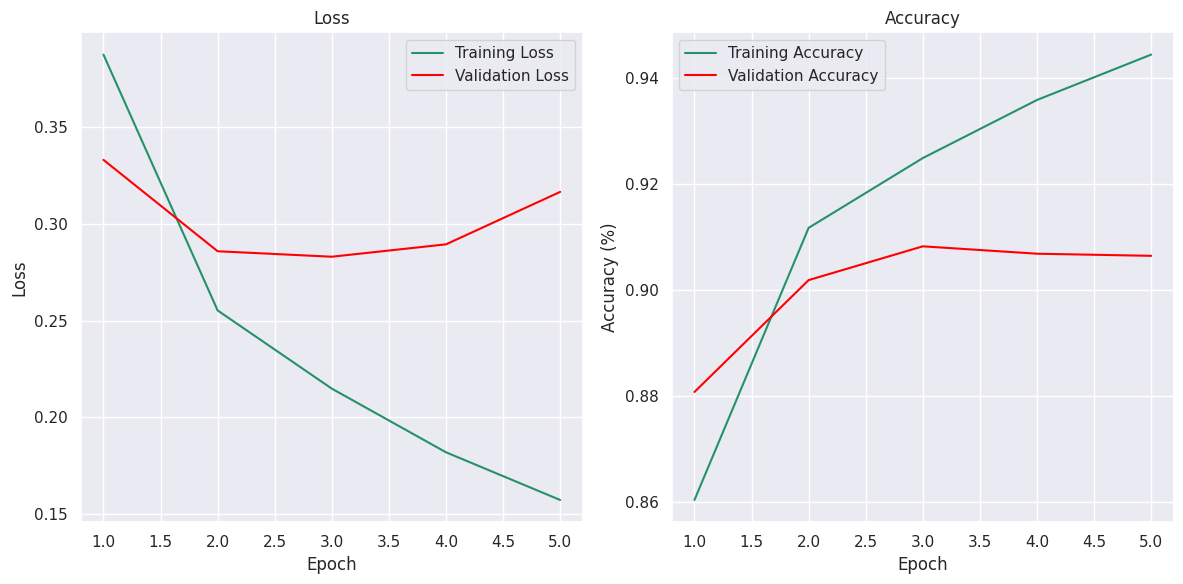

0.9059999585151672

In [ ]:
CFG.epochs=5
baseline = test_model(CharLM)
evaluate(baseline, eval_dataloader)

As expected. Meh. And overfits

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4315
acc: 84.19


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3604
acc: 87.76
Epoch: 1/6:
	Train:                                  
		train_loss = 0.43145                                  
		train acc = 0.842%                                  
	Val:                                  
		val loss = 0.36039                                   
		val acc = 0.878%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2669
acc: 90.88


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3248
acc: 88.81
Epoch: 2/6:
	Train:                                  
		train_loss = 0.26689                                  
		train acc = 0.909%                                  
	Val:                                  
		val loss = 0.32475                                   
		val acc = 0.888%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2207
acc: 92.43


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2761
acc: 90.43
Epoch: 3/6:
	Train:                                  
		train_loss = 0.22074                                  
		train acc = 0.924%                                  
	Val:                                  
		val loss = 0.27614                                   
		val acc = 0.904%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1871
acc: 93.5


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2845
acc: 90.9
Epoch: 4/6:
	Train:                                  
		train_loss = 0.18713                                  
		train acc = 0.935%                                  
	Val:                                  
		val loss = 0.28451                                   
		val acc = 0.909%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1601
acc: 94.38


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2879
acc: 91.18
Epoch: 5/6:
	Train:                                  
		train_loss = 0.16012                                  
		train acc = 0.944%                                  
	Val:                                  
		val loss = 0.28785                                   
		val acc = 0.912%


Epoch Train: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1045
acc: 96.38


Epoch Val: 6:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3187
acc: 90.62
Epoch: 6/6:
	Train:                                  
		train_loss = 0.16012                                  
		train acc = 0.944%                                  
	Val:                                  
		val loss = 0.28785                                   
		val acc = 0.912%


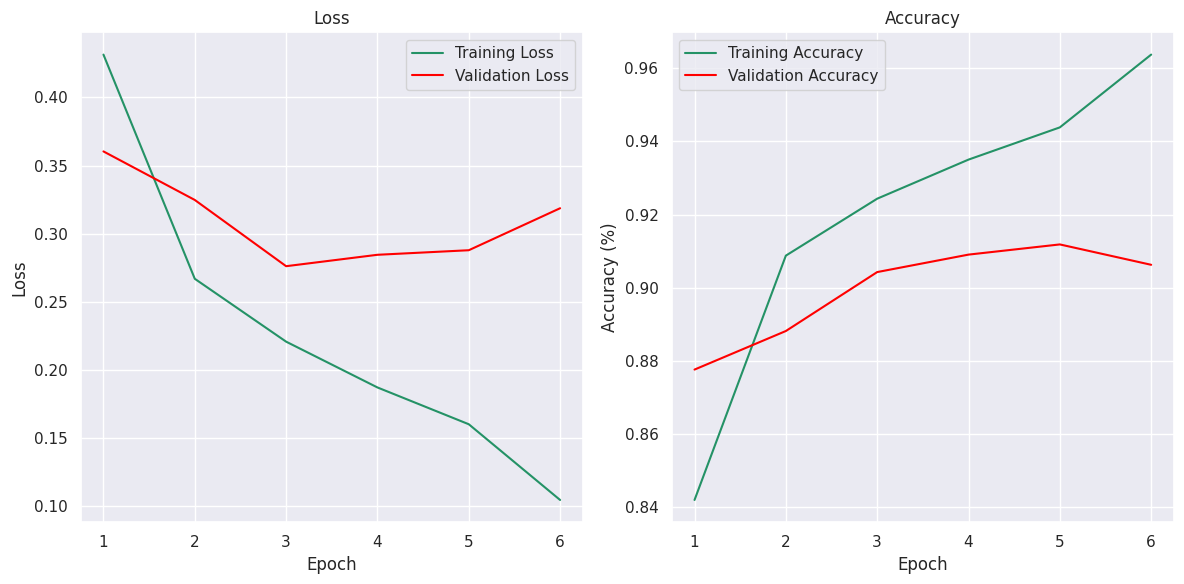

In [ ]:
CFG.epochs = 6
best_model = test_model(RNNModel, lr=3e-4)

In [ ]:
evaluate(best_model, eval_dataloader)

0.9057999849319458

Had to stop it here since there won't be any space to improve :)
However this is a result for a simple RNN, not bidirectional, max aggregation, 2 rnn layers and 2 fc layers with 0.2 dropout, tanh for rnn and relu for fc, 4e-4 lr and default weight decay

### Improving model experiment (4 points /2 each)

one change per experiment

#### Experiment 1: bidirectional RNN

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4326
acc: 84.1


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3146
acc: 89.43
Epoch: 1/3:
	Train:                                  
		train_loss = 0.43263                                  
		train acc = 0.841%                                  
	Val:                                  
		val loss = 0.31462                                   
		val acc = 0.894%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2671
acc: 90.92


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2918
acc: 90.01
Epoch: 2/3:
	Train:                                  
		train_loss = 0.26709                                  
		train acc = 0.909%                                  
	Val:                                  
		val loss = 0.2918                                   
		val acc = 0.9%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.224
acc: 92.35


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2755
acc: 91.2
Epoch: 3/3:
	Train:                                  
		train_loss = 0.22396                                  
		train acc = 0.923%                                  
	Val:                                  
		val loss = 0.27551                                   
		val acc = 0.912%


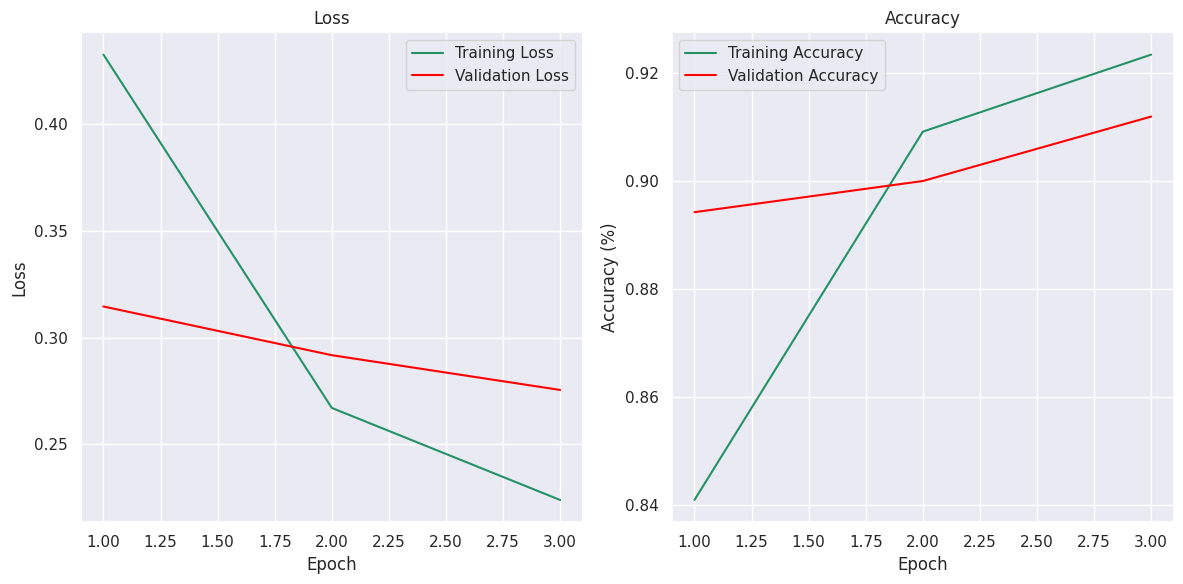

In [ ]:
CFG.epochs = 3
best_model = test_model(RNNModel)

In [ ]:
dummy_model = RNNModel(vocab_size=len(vocab), hidden_dim=512, num_classes=4).to(device)
dummy_model.load_state_dict(best_model)
evaluate(dummy_model, eval_dataloader)

0.9091999530792236

Definitelly bidirectional shows better results than not bi- one, but it takes a bit longer time and it seems that the accuracy trend goes uphill without increase in cos distance between two lines (however loss has it). Difference is minumal 1%!

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4425
acc: 84.08


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.328
acc: 88.95
Epoch: 1/10:
	Train:                                  
		train_loss = 0.44246                                  
		train acc = 0.841%                                  
	Val:                                  
		val loss = 0.32799                                   
		val acc = 0.89%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2812
acc: 90.52


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2866
acc: 90.29
Epoch: 2/10:
	Train:                                  
		train_loss = 0.28121                                  
		train acc = 0.905%                                  
	Val:                                  
		val loss = 0.28664                                   
		val acc = 0.903%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2325
acc: 92.1


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2932
acc: 90.41
Epoch: 3/10:
	Train:                                  
		train_loss = 0.23246                                  
		train acc = 0.921%                                  
	Val:                                  
		val loss = 0.29322                                   
		val acc = 0.904%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1997
acc: 93.22


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3028
acc: 90.15
Epoch: 4/10:
	Train:                                  
		train_loss = 0.23246                                  
		train acc = 0.921%                                  
	Val:                                  
		val loss = 0.29322                                   
		val acc = 0.904%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1732
acc: 94.03


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2983
acc: 90.45
Epoch: 5/10:
	Train:                                  
		train_loss = 0.17325                                  
		train acc = 0.94%                                  
	Val:                                  
		val loss = 0.29834                                   
		val acc = 0.904%


Epoch Train: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1495
acc: 94.89


Epoch Val: 6:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2933
acc: 90.82
Epoch: 6/10:
	Train:                                  
		train_loss = 0.14948                                  
		train acc = 0.949%                                  
	Val:                                  
		val loss = 0.29332                                   
		val acc = 0.908%


Epoch Train: 7:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1298
acc: 95.46


Epoch Val: 7:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3287
acc: 90.61
Epoch: 7/10:
	Train:                                  
		train_loss = 0.14948                                  
		train acc = 0.949%                                  
	Val:                                  
		val loss = 0.29332                                   
		val acc = 0.908%


Epoch Train: 8:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1141
acc: 96.01


Epoch Val: 8:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3275
acc: 90.61
Epoch: 8/10:
	Train:                                  
		train_loss = 0.14948                                  
		train acc = 0.949%                                  
	Val:                                  
		val loss = 0.29332                                   
		val acc = 0.908%


Epoch Train: 9:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.0983
acc: 96.55


Epoch Val: 9:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3778
acc: 90.47
Epoch: 9/10:
	Train:                                  
		train_loss = 0.14948                                  
		train acc = 0.949%                                  
	Val:                                  
		val loss = 0.29332                                   
		val acc = 0.908%


Epoch Train: 10:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.0875
acc: 96.91


Epoch Val: 10:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3625
acc: 90.86
Epoch: 10/10:
	Train:                                  
		train_loss = 0.08745                                  
		train acc = 0.969%                                  
	Val:                                  
		val loss = 0.36249                                   
		val acc = 0.909%


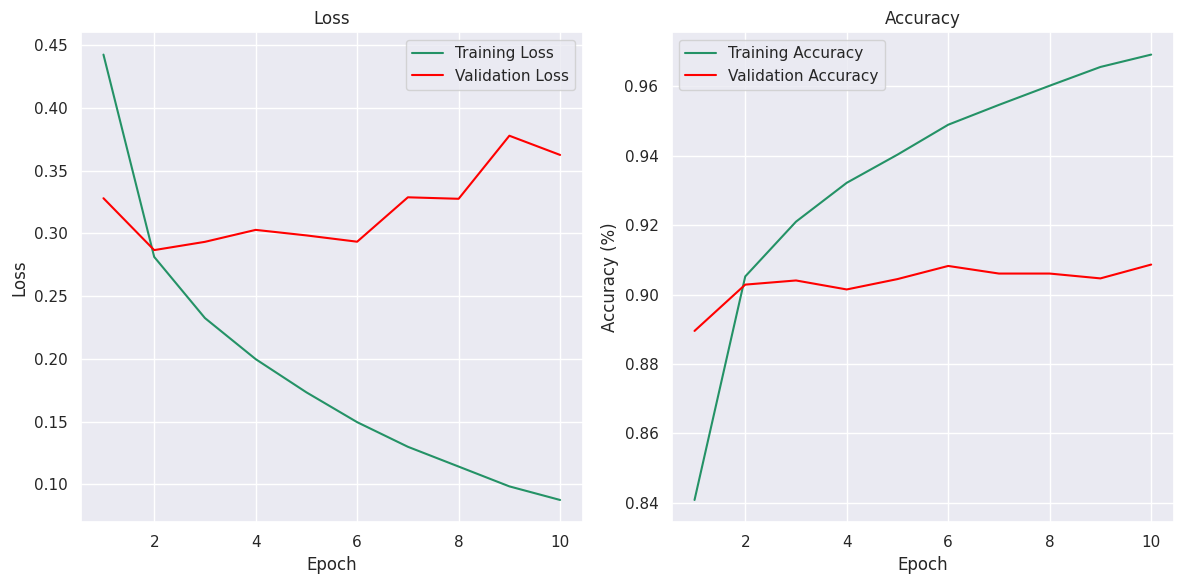

0.9081999659538269

In [ ]:
CFG.epochs = 10
model = RNNModel(vocab_size=len(vocab), hidden_dim=512, num_classes=4, bi=True, rnn_layers=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=4e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX).to(device)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.5)
best_model, history = fit(model, optimizer, criterion, scheduler, train_dataloader, eval_dataloader)
plot_loss_and_acc(*history)
evaluate(best_model, eval_dataloader)

This experiment was with 3 rnn layers.
However here we see similar result but on 10 epochs and a clear overfit - loss keeps growing. To boost the quality we could use some regularization, larger dropouts, use another model etc.

#### Experiment 2: Try more complex models (LSTM)

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, vocab_size: int, hidden_dim: int = 512, num_classes: int = 4):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim)
    self.drop = nn.Dropout(0.4)
    self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=3, batch_first=True, bidirectional=True)
    self.fc_1 = nn.Linear(in_features=hidden_dim*2, out_features=hidden_dim//2)
    self.fc_2 = nn.Linear(in_features=hidden_dim//2, out_features=num_classes)


  def forward(self, x):
    embeddings = self.embedding(x)
    x, last_cell = self.lstm(embeddings)
    x = F.tanh(x.mean(dim=1))
    x = self.fc_1(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_2(x)
    return x

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3955
acc: 86.15


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2962
acc: 90.39
Epoch: 1/3:
	Train:                                  
		train_loss = 0.39552                                  
		train acc = 0.862%                                  
	Val:                                  
		val loss = 0.29621                                   
		val acc = 0.904%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2324
acc: 92.25


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2708
acc: 91.4
Epoch: 2/3:
	Train:                                  
		train_loss = 0.23244                                  
		train acc = 0.922%                                  
	Val:                                  
		val loss = 0.2708                                   
		val acc = 0.914%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1655
acc: 94.45


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2619
acc: 91.6
Epoch: 3/3:
	Train:                                  
		train_loss = 0.16545                                  
		train acc = 0.945%                                  
	Val:                                  
		val loss = 0.26195                                   
		val acc = 0.916%


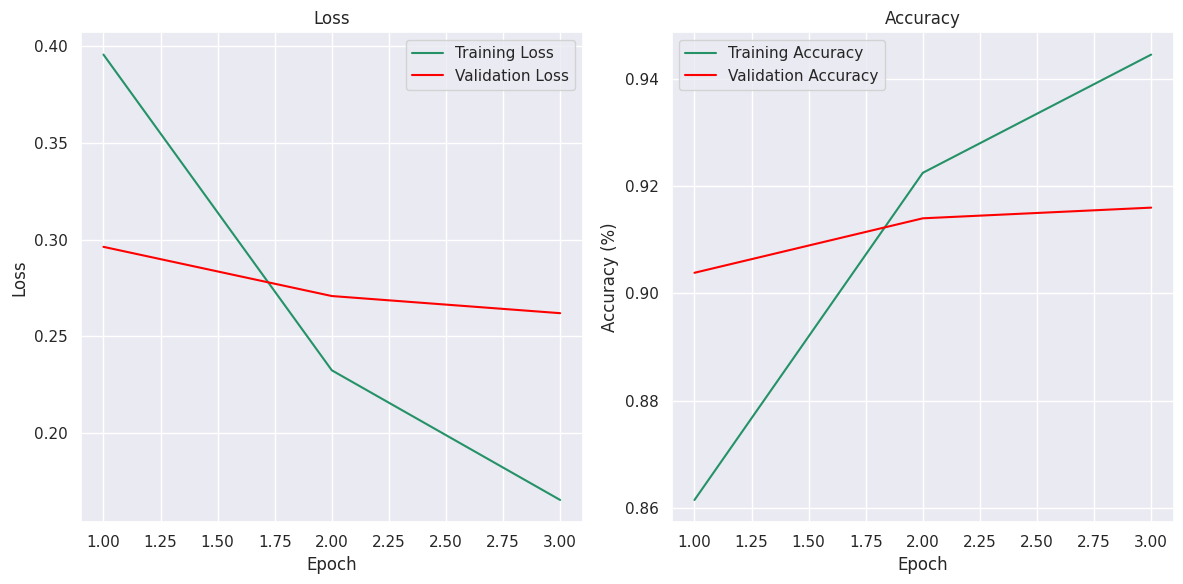

In [ ]:
CFG.epochs=3
best_model = test_model(LSTMModel, lr=3e-4)

In [ ]:
evaluate(best_model, eval_dataloader)

0.9156000018119812

Welp, the goal was to reach 91.5% accuracy. We did it with LSTM on third epoch.
Model works noticeably longer than even bi-rnn with 4 layers.
3 recurrent layers, bidirectional, 2fc. agg is mean. I'd consider it a proper choice of activation and hyperparameters.

#### Experiment 3: Max aggregation

Well, LSTM could reach the goal from second-third epoch , so I'd consider this goal to be achieved and task completed. However it's peculiar to obser lstm with max aggregation

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3813
acc: 86.57


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2981
acc: 90.64
Epoch: 1/5:
	Train:                                  
		train_loss = 0.38132                                  
		train acc = 0.866%                                  
	Val:                                  
		val loss = 0.29809                                   
		val acc = 0.906%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2221
acc: 92.49


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2627
acc: 91.34
Epoch: 2/5:
	Train:                                  
		train_loss = 0.22214                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.26268                                   
		val acc = 0.913%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1493
acc: 94.89


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2762
acc: 91.34
Epoch: 3/5:
	Train:                                  
		train_loss = 0.22214                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.26268                                   
		val acc = 0.913%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.0906
acc: 96.89


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3245
acc: 91.04
Epoch: 4/5:
	Train:                                  
		train_loss = 0.22214                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.26268                                   
		val acc = 0.913%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.0538
acc: 98.11


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.4046
acc: 90.88
Epoch: 5/5:
	Train:                                  
		train_loss = 0.22214                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.26268                                   
		val acc = 0.913%


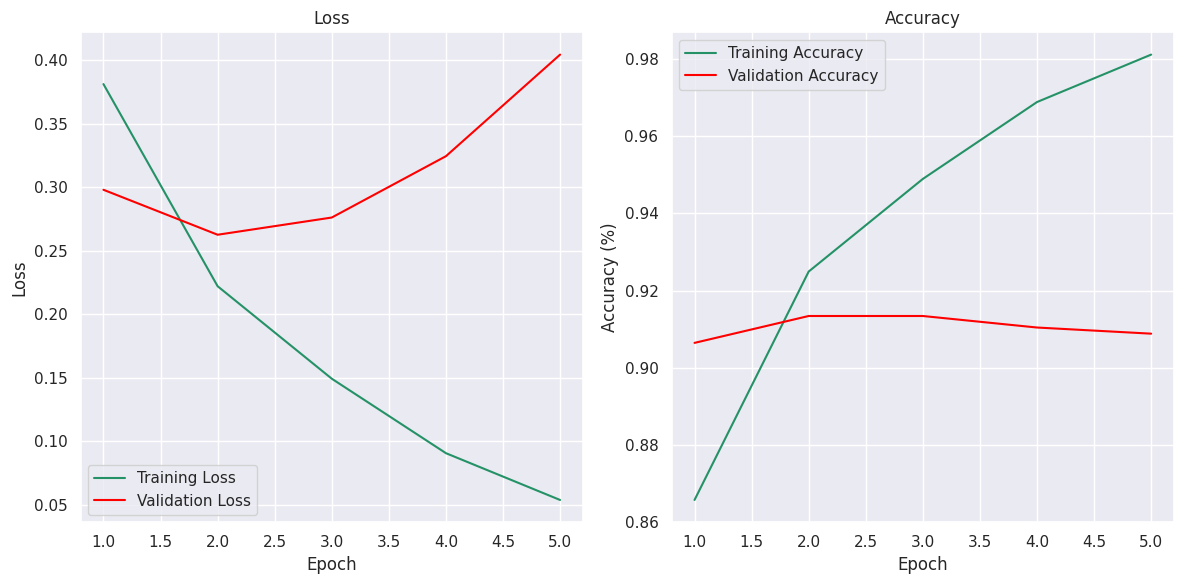

0.9083999991416931

In [ ]:
CFG.epochs = 5
best_model = test_model(LSTMModel, bi=True, rnn_layers=3)
evaluate(best_model, eval_dataloader)

Max aggregation works a bit worse. also look at that loss after 2nd epoch! model learns the train data too well. Weight decay could help, as well as increasing dropout (up tp 0.8) and adding batchnorm.

#### Experiment 4: GRU with increased recurrent layers

Let's create a horrendous monster. we take 3 reccurent layers, 3 fc layers, add batchnorm and dropouts, mean aggretation. all over GRU.

In [ ]:
class GRUModel(nn.Module):
  def __init__(self, vocab_size: int, hidden_dim: int = 512, num_classes: int = 4, rnn_layers=3, bi=True):
    super(GRUModel, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim, bi = True, rnn_layers = 3)
    self.drop = nn.Dropout(0.2)
    self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=rnn_layers, batch_first=True, bidirectional=bi)
    self.fc_1 = nn.Linear(in_features=hidden_dim*2, out_features=hidden_dim//2)
    self.bn_1 = nn.BatchNorm1d(num_features=hidden_dim//2)
    self.fc_2 = nn.Linear(in_features=hidden_dim//2, out_features=hidden_dim//4)
    self.bn_2 = nn.BatchNorm1d(num_features=hidden_dim//4)
    self.fc_3 = nn.Linear(in_features=hidden_dim//4, out_features=num_classes)
    # MOAR LAYERZ! MOAR BATCHNORM! MORE DROPOUT! GO FOR THE EYES BOO! GO FOR THE EYES! YAARGH!
    #What could possibly go wrong?

  def forward(self, x):
    embeddings = self.embedding(x)
    x, last_cell = self.rnn(embeddings)
    x = F.tanh(x.mean(dim=1))
    x = self.fc_1(x)
    x = self.bn_1(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_2(x)
    x = self.bn_2(x)
    x = F.relu(x)
    x = self.drop(x)
    x = self.fc_3(x)
    return x

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3956
acc: 86.42


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3049
acc: 90.35
Epoch: 1/3:
	Train:                                  
		train_loss = 0.39564                                  
		train acc = 0.864%                                  
	Val:                                  
		val loss = 0.30487                                   
		val acc = 0.903%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2368
acc: 92.05


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2728
acc: 90.98
Epoch: 2/3:
	Train:                                  
		train_loss = 0.23675                                  
		train acc = 0.921%                                  
	Val:                                  
		val loss = 0.27283                                   
		val acc = 0.91%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1672
acc: 94.5


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2631
acc: 91.32
Epoch: 3/3:
	Train:                                  
		train_loss = 0.16715                                  
		train acc = 0.945%                                  
	Val:                                  
		val loss = 0.2631                                   
		val acc = 0.913%


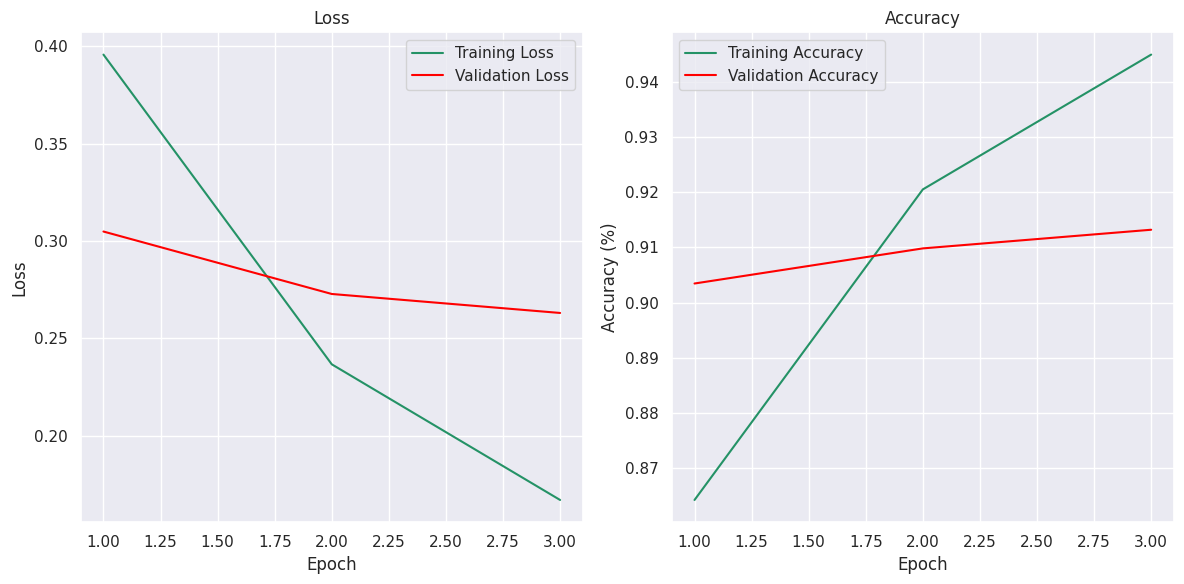

NameError: name 'best_model' is not defined

In [ ]:
CFG.epochs=3
best_model = test_model(GRUModel, bi=True, rnn_layers=3)
evaluate(best_model, eval_dataloader)

Even such an unoptimized monstrosity like this one shows stable 91+% after 3 epoch and an up trend. Difference in acc on train and val is ~3% which is something to start worrying about (from my experience it will keep growing), so batchnorm ain't really helping.

#### Experiment 5: Tune hyperparameters

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.5856
acc: 77.95


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.4054
acc: 86.11
Epoch: 1/6:
	Train:                                  
		train_loss = 0.58558                                  
		train acc = 0.78%                                  
	Val:                                  
		val loss = 0.40535                                   
		val acc = 0.861%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3421
acc: 88.62


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3568
acc: 88.28
Epoch: 2/6:
	Train:                                  
		train_loss = 0.34207                                  
		train acc = 0.886%                                  
	Val:                                  
		val loss = 0.35681                                   
		val acc = 0.883%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2929
acc: 90.37


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3268
acc: 89.23
Epoch: 3/6:
	Train:                                  
		train_loss = 0.29287                                  
		train acc = 0.904%                                  
	Val:                                  
		val loss = 0.32683                                   
		val acc = 0.892%


Epoch Train: 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2558
acc: 91.61


Epoch Val: 4:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3261
acc: 89.81
Epoch: 4/6:
	Train:                                  
		train_loss = 0.25579                                  
		train acc = 0.916%                                  
	Val:                                  
		val loss = 0.32613                                   
		val acc = 0.898%


Epoch Train: 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2276
acc: 92.49


Epoch Val: 5:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.3057
acc: 90.29
Epoch: 5/6:
	Train:                                  
		train_loss = 0.22764                                  
		train acc = 0.925%                                  
	Val:                                  
		val loss = 0.30567                                   
		val acc = 0.903%


Epoch Train: 6:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1778
acc: 94.16


Epoch Val: 6:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2937
acc: 91.16
Epoch: 6/6:
	Train:                                  
		train_loss = 0.17785                                  
		train acc = 0.942%                                  
	Val:                                  
		val loss = 0.29369                                   
		val acc = 0.912%


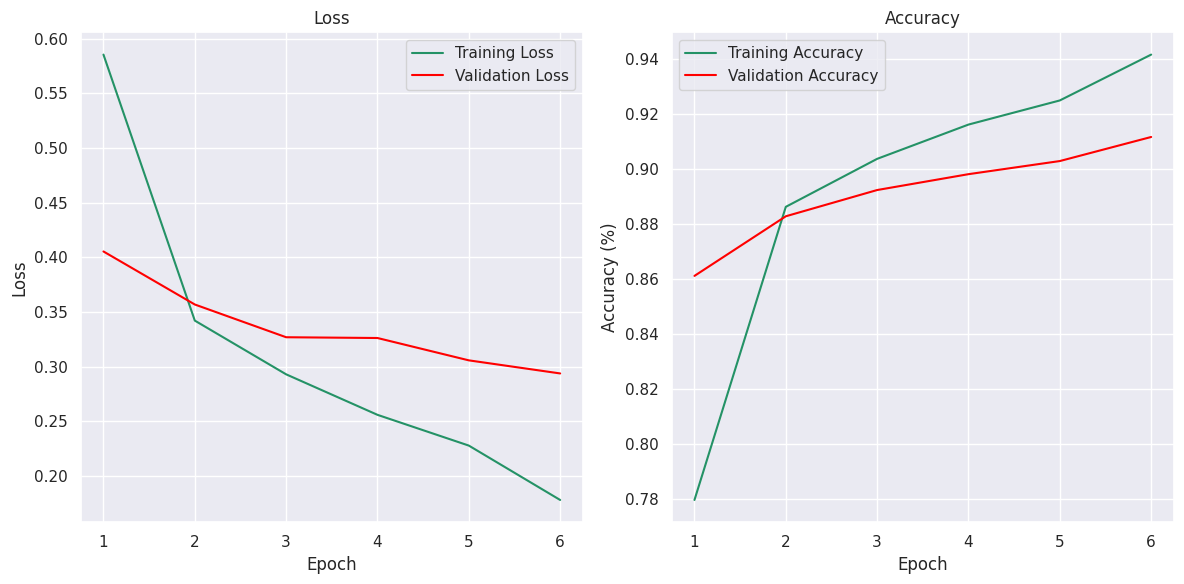

0.9111999869346619

In [ ]:
CFG.epochs = 6
best_model = test_model(RNNModel, hd=1024, rnn_layers = 4, lr=3e-4, bi=True)
evaluate(best_model, eval_dataloader)

RNN shows a steady growth however it's unlikely to reach 92. More layers and dimensions increase model complexity so it takes longer to train (approaching LSTM time complexity).
Train graph also shows steeper curve so eventually it will overfit.

### Increase accuracy (3 points)

Since we've achieved target accuracy with basic LSTM (3 layers, 2 fc, bidirectional, mean aggregation, dropout 0.4, lr 3e-4, default weight decay), there is no need to come up with a different solution. If I had more time, I would've tried to squeeze additional 0.02 frim RRN by using dropout to prevent overfit, but I've got just so much time and can't dedicate more to experiments, so I'll just reproduce experiment 1 here.

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch Train: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3955
acc: 86.15


Epoch Val: 1:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2962
acc: 90.39
Epoch: 1/3:
	Train:                                  
		train_loss = 0.39552                                  
		train acc = 0.862%                                  
	Val:                                  
		val loss = 0.29621                                   
		val acc = 0.904%


Epoch Train: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2324
acc: 92.25


Epoch Val: 2:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2708
acc: 91.4
Epoch: 2/3:
	Train:                                  
		train_loss = 0.23244                                  
		train acc = 0.922%                                  
	Val:                                  
		val loss = 0.2708                                   
		val acc = 0.914%


Epoch Train: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1655
acc: 94.45


Epoch Val: 3:   0%|          | 0/157 [00:00<?, ?it/s]

loss: 0.2619
acc: 91.6
Epoch: 3/3:
	Train:                                  
		train_loss = 0.16545                                  
		train acc = 0.945%                                  
	Val:                                  
		val loss = 0.26195                                   
		val acc = 0.916%


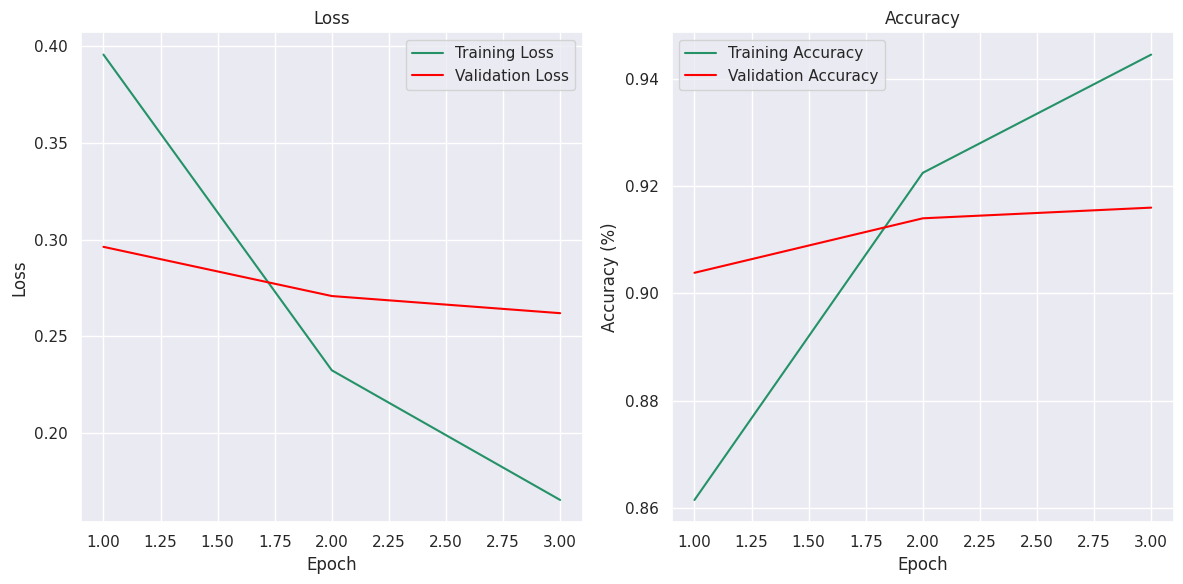

In [ ]:
CFG.epochs=3
best_model = test_model(LSTMModel, lr=3e-4)

In [ ]:
evaluate(best_model, eval_dataloader)

0.9156000018119812

## Write a report (2 points)

## Report on RNN, LSTM, and GRU for AG_NEWS Dataset


1. Show what experiments have increased performance
2. Analyze training graphs
3. Select optimal model

### Introduction

Recurrent Neural Networks (RNN), Long Short-Term Memory (LSTM), and Gated Recurrent Unit (GRU) models have shown promising results in text classification tasks. This report presents the findings of various experiments conducted on the AG_NEWS dataset to identify the optimal model for achieving high classification accuracy. Our target was to surpass a benchmark accuracy of 91.5%, which was successfully achieved.



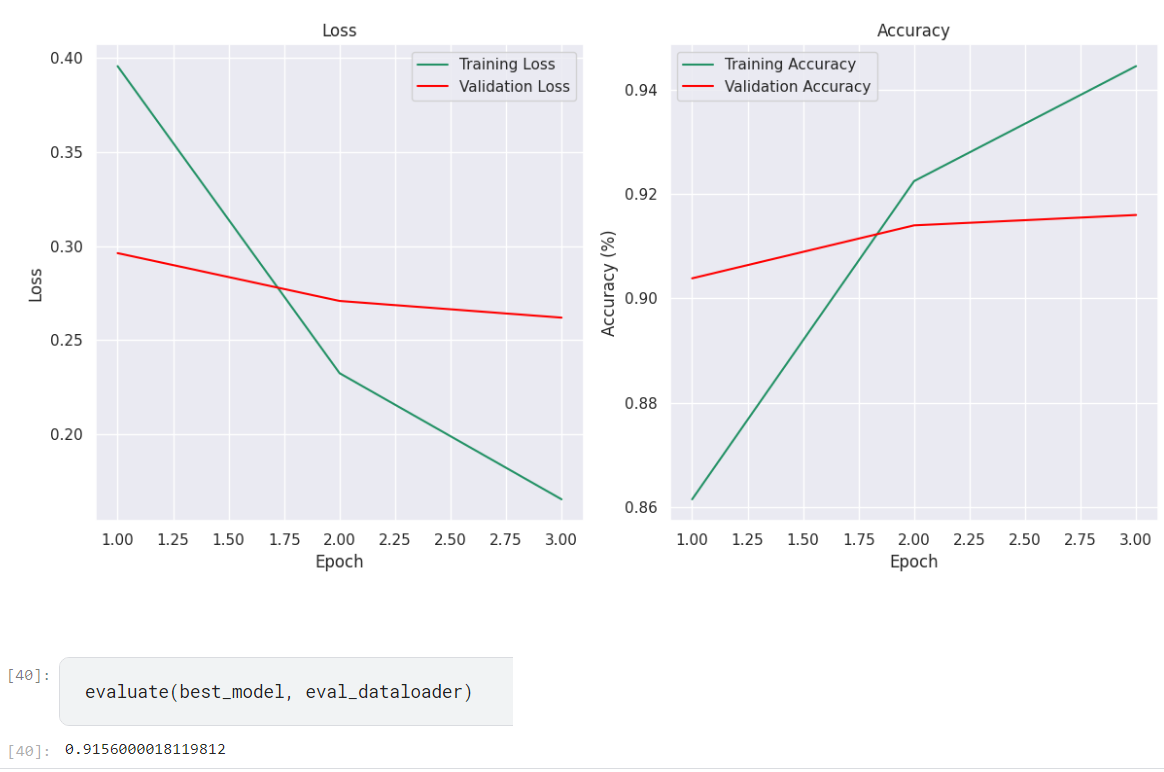

### Experiment Overview

#### Basic RNN

- **Configuration**: Basic RNN with early stopping after 6 epochs due to computational constraints.
- **Result**: Achieved a maximum accuracy of 90.5%.
- **Observation**: Although promising, the model required further optimization to meet the target accuracy.



#### Experiment 1: Bidirectional RNN

- **Configuration**: 2 recurrent layers, bidirectional, 2 fully connected (FC) layers, mean aggregation, dropout 0.2, learning rate 3e-4, default weight decay.
- **Result**: Achieved 90.9% accuracy on the third epoch with a ponetial to go highe..
- **Observation**: This one learns much faster than RNN (on epochs, but each epoch takes longer time) and already on third epoch achieved ~91% with no signs of overfitting, so I'd say it has potential to reach the target 91.5% before starting to overfit. Mean aggregaion helps as well even on low dropout.

#### Experiment 2: LSTM with Mean Aggregation

- **Configuration**: 3 recurrent layers, bidirectional, 2 fully connected (FC) layers, mean aggregation, dropout 0.4, learning rate 3e-4, default weight decay.
- **Result**: Surpassed the target by achieving 91.56% accuracy on the third epoch.
- **Observation**: The LSTM model, despite its longer computation time compared to a bi-directional RNN with 4 layers, was effective due to the optimal choice of activation and hyperparameters.

#### Experiment 3: LSTM with Max Aggregation

- **Configuration**: Similar to Experiment 1 but with max aggregation.
- **Result**: Reached a peak accuracy of 90.84% over 5 epochs.
- **Observation**: The model showed signs of overfitting post the 2nd epoch. Suggestions for improvement include increasing dropout up to 0.8, introducing weight decay, and adding batch normalization.

#### Experiment 4: GRU with Batch Normalization and Dropout

- **Configuration**: 3 recurrent layers, 3 FC layers, batch normalization, dropout, mean aggregation, all over GRU.
- **Result**: Achieved 91.3% accuracy within 3 epochs.
- **Observation**: Despite being somewhat unoptimized and considered a "monstrosity", the GRU model showed a stable performance of over 91% by the 3rd epoch, with a growing discrepancy between training and validation accuracy suggesting the onset of overfitting.

#### Experiment 5: Hyperparameter Tuned RNN

- **Configuration**: RNN with increased layers (3) and dimensions (1024 vs 512), trained for 6 epochs.
- **Result**: Achieved 91.1% accuracy.
- **Observation**: Showed steady growth but is unlikely to surpass 92% due to signs of potential overfitting indicated by the steep learning curve.

### Analysis of Training Graphs

- **Overfitting Trends**: Across the experiments, models tend to overfit after several epochs, particularly notable in experiments 3 and 4.

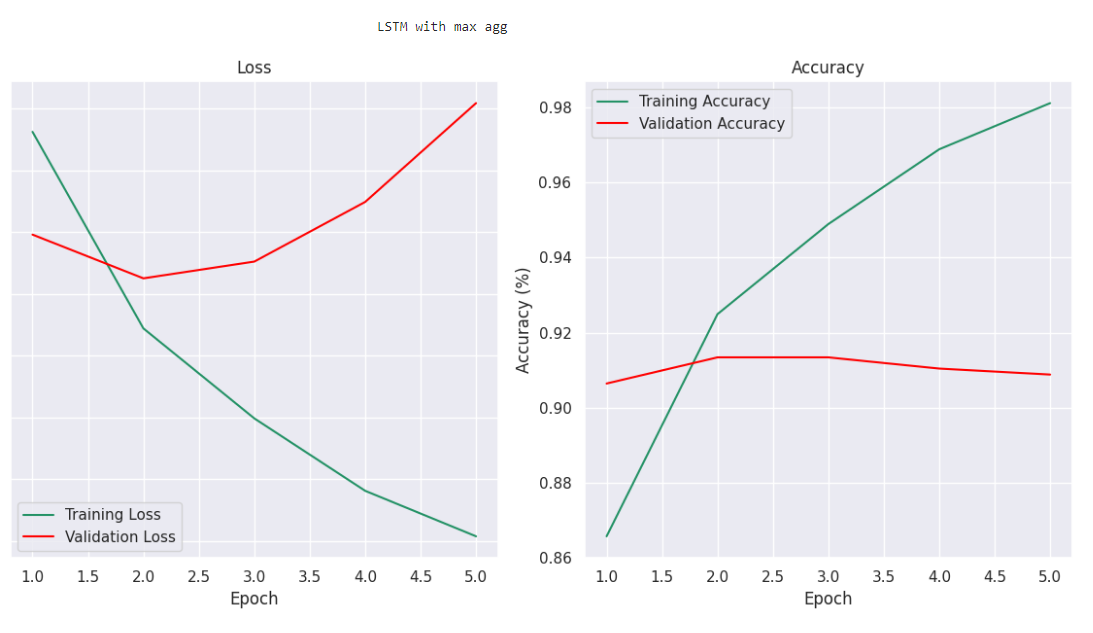

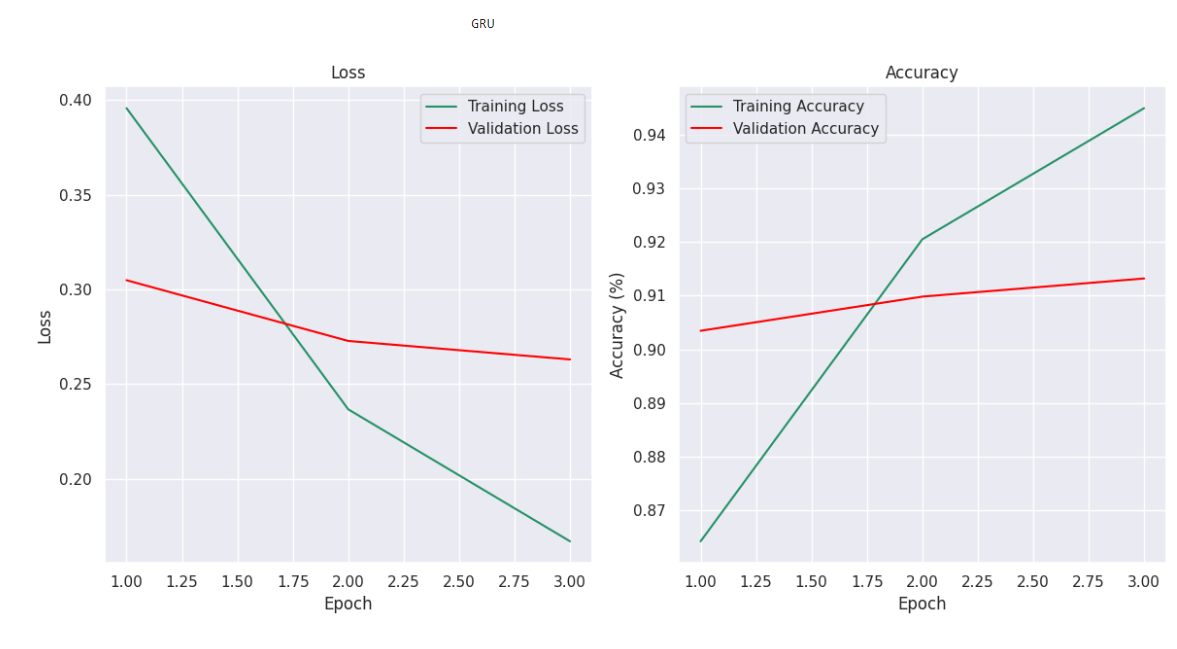

Also bidirectional rnn on 3rd epoch has shown a good result and unlike other models it doesnt' show a trend to overfit - train and val lines grow steadily. Other models tend to diverge much.

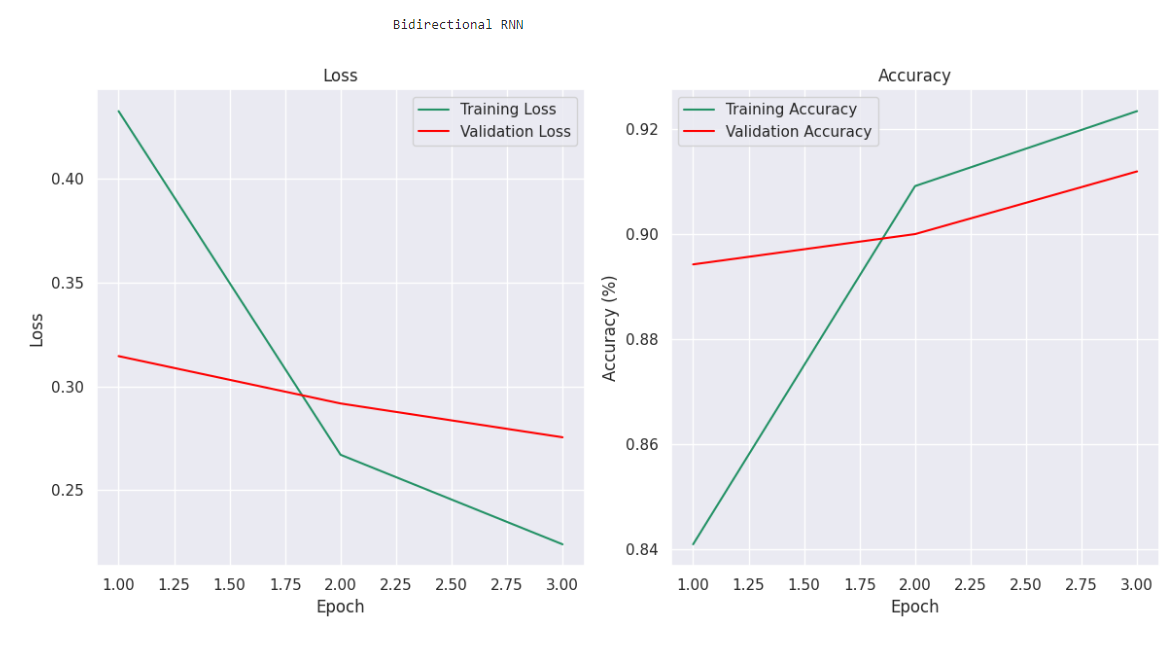

**Peculiar observation:** On the first epoch most models get higher accuracy score on eval than on train dataset which later gets corrected.
This is due to the initial model simplicity (model doesn't know much on first batches but we still add the score of the first batches) and evaluation done after the train, but the first batches low scores still take effect.

#### Other considerations

- **Early stopping and saving best model**: Since models tend to overfit we could use early stopping if the accuracy on eval drops lower a cetain minumum as well as implementing (done) saving the best state of the model that has shown the highest results on evaluation.


- **Learning Rate and Decay**: Use of weight decay and step scheduler generally lowered performance, suggesting a delicate balance is required in their application.


- **Model Complexity vs. Training Time**: Increased model complexity, through additional layers and higher dimensions, led to longer training times, approaching those of the LSTM models.


- **Embeddings and Tokenizer Adjustments**: Modifications in embeddings, such as removing specific tokens (< br >) and adjusting the tokenizer, could potentially improve model performance.

- **Dropout Adjustments**: Experimenting with dropout rates to prevent overfitting without compromising model accuracy could be beneficial.

- **Padding Strategy**: Although not implemented in this series of experiments, revisiting the padding approach used in the dataset preprocessing could offer marginal gains in model performance.

### Optimal Model Selection

Given the experimental results, the **LSTM model with mean aggregation** (Experiment 2) is selected as the optimal model. It not only achieved the target accuracy but did so efficiently, balancing model complexity with computational demands. The configuration of 3 recurrent layers, bidirectional setup, and 2 FC layers, complemented by appropriate dropout and learning rate settings, proved to be highly effective for the AG_NEWS dataset.


> **Model:** LSTM

> **Bidrectional:** True

> **Aggregation method:** mean

> **Recurrent layers:** 3

> **LSTM activation:** tanh

> **Hidden dimensions:** 512 (1024 since bidirectional)->256

> **FC layers:** 2

> **FC acivation:** relu

> **Dropout:** 0.4

> **Batch size:** 32

> **Embeddings size:** vocab size

> **Embeddings dim:** 512

> **Loss function:** CrossEntropy (with logits)

> **Optimizer:** Adam

> **LR:** Karpaty constant

> **Weight decay:** default

> **Scheduler:** False

### Conclusion

(*LLMs helped me summarize all the info above* )

The series of experiments conducted on the AG_NEWS dataset illustrate the nuanced balance required between model architecture, hyperparameters, and training strategies to achieve optimal performance in text classification tasks. The LSTM model with mean aggregation emerged as the most effective, surpassing the target accuracy with a significant (not really but there is potential to do so) margin. Future work should explore further optimizations, particularly in preprocessing and regularization techniques, to enhance model robustness and performance.